<a href="https://colab.research.google.com/github/dmolinasi/TalentoTechDaniela_Molina/blob/main/Modelo_SeireTemporal_IOWA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importar las librerias
#========================================================================================
import pandas as pd
import numpy as np
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')


In [2]:
from google.colab import drive
import pandas as pd

# Montar Google Drive
drive.mount('/content/drive')

# Cargar dataframe
#========================================================================================


Mounted at /content/drive


In [4]:

# Cargar dataframe
#========================================================================================
try:
    # Leer el archivo CSV ubicado en Google Drive y asigna los datos a la variable df_resultados
    ruta = "/content/drive/MyDrive/AN 2/"
    archivo = "iowa_liquor_sales_filtered.csv"
    iowa_liquor = pd.read_csv(ruta + archivo)

    # Si la lectura del archivo es exitosa, imprime un mensaje indicando que el dataset se cargó correctamente
    print("El dataset se cargó exitosamente")

# Si se produce un error específico de "FileNotFoundError" (archivo no encontrado), ejecuta este bloque de código
except FileNotFoundError as e:

    # Imprime un mensaje de error personalizado indicando que el archivo no se pudo encontrar, junto con los detalles específicos del error
    print(f"Error: El archivo no se puede encontrar. Detalles: {e}")

# Si se produce cualquier otro tipo de error, ejecuta este bloque de código
except Exception as e:

    # Imprime un mensaje de error genérico indicando que ocurrió un error inesperado, junto con los detalles específicos del error
    print(f"Error inesperado: {e}")



El dataset se cargó exitosamente


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
#Para eliminar los valores NA
#========================================================================================
iowa_liquor = iowa_liquor.dropna()
print("El número total de puntos de datos después de eliminar las filas con valores faltantes es:", len(iowa_liquor))

El número total de puntos de datos después de eliminar las filas con valores faltantes es: 3870101


In [16]:
# Funciones para Entrenar, validar y pronosticar
#========================================================================================
def prepare_time_series_data(df, county=None):
    """
    Prepara los datos para el análisis de series temporales
    """
    temp_df = df.copy()
    temp_df['Date'] = pd.to_datetime(temp_df['Date'])

    if county:
        temp_df = temp_df[temp_df['County'] == county]

    daily_sales = temp_df.groupby('Date')['Sale (Dollars)'].sum().reset_index()
    daily_sales.set_index('Date', inplace=True)
    monthly_sales = daily_sales.resample('M').sum()

    return monthly_sales

def split_data_for_validation(data):
    """
    Divide los datos en entrenamiento y validación
    """
    train = data[:'2022-06-30']
    #porque esta fracción de entrenamiento
    validation = data['2022-07-01':'2022-12-31']

    return train, validation

def calculate_mape(y_true, y_pred):
    """
    Calcula el MAPE manejando valores cero y datos faltantes
    """
    if len(y_true) == 0 or len(y_pred) == 0:
        return None

    # Eliminar pares donde y_true es cero o nulo
    mask = (y_true != 0) & (~np.isnan(y_true)) & (~np.isnan(y_pred))
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    if len(y_true) == 0:
        return None

    # Calcular MAPE
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return float(mape)

def find_best_parameters(train_data, validation_data):
    """
    Encuentra los mejores parámetros para el modelo SARIMA
    """
    best_rmse = float('inf')
    best_params = None
    best_model = None
    best_forecast = None

    p_values = [0, 1, 2]
    d_values = [1]
    q_values = [0, 1, 2]
    P_values = [0, 1]
    D_values = [1]
    Q_values = [0, 1]
    s_values = [12]

    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            for s in s_values:
                                try:
                                    model = SARIMAX(train_data,
                                                  order=(p, d, q),
                                                  seasonal_order=(P, D, Q, s),
                                                  enforce_stationarity=False,
                                                  enforce_invertibility=False)

                                    model_fit = model.fit(disp=False)
                                    forecast = model_fit.forecast(steps=len(validation_data))
                                    forecast.index = validation_data.index

                                    rmse = np.sqrt(mean_squared_error(validation_data, forecast))

                                    if rmse < best_rmse:
                                        best_rmse = rmse
                                        best_params = (p, d, q, P, D, Q, s)
                                        best_model = model_fit
                                        best_forecast = forecast

                                except:
                                    continue

    return best_model, best_forecast, best_params, best_rmse

def train_and_validate_model(train_data, validation_data):
    """
    Entrena el modelo y realiza validación
    """
    try:
        print("Buscando mejores parámetros...")
        best_model, validation_forecast, best_params, best_rmse = find_best_parameters(
            train_data, validation_data
        )

        if best_model is None:
            return None, None, None

        y_true = validation_data.values.flatten()
        y_pred = validation_forecast.values.flatten()

        mape = calculate_mape(y_true, y_pred)
        mae = float(mean_absolute_error(y_true, y_pred))

        validation_metrics = {
            'RMSE': float(best_rmse),
            'MAE': mae,
            'MAPE': mape if mape is not None else 0,
            'Params': best_params
        }

        print(f"Mejores parámetros encontrados: {best_params}")
        return best_model, validation_forecast, validation_metrics

    except Exception as e:
        print(f"Error en el entrenamiento del modelo: {str(e)}")
        return None, None, None

def train_final_model(data, best_params):
    """
    Entrena el modelo final usando los mejores parámetros
    """
    if best_params is None:
        best_params = (1, 1, 1, 1, 1, 1, 12)

    p, d, q, P, D, Q, s = best_params
    final_model = SARIMAX(data[:'2022-12-31'],
                         order=(p, d, q),
                         seasonal_order=(P, D, Q, s),
                         enforce_stationarity=False,
                         enforce_invertibility=False)

    final_model_fit = final_model.fit(disp=False)
    return final_model_fit

def make_forecast_2023(model):
    """
    Realiza el pronóstico para 2023
    """
    forecast_index = pd.date_range(start='2023-01-01', end='2023-06-30', freq='M')
    forecast = model.forecast(steps=6)
    forecast.index = forecast_index
    return forecast

def plot_county_results(train_data, validation_data, validation_forecast, final_forecast, county_name="General"):
    """
    Visualiza resultados para un condado específico
    """
    plt.figure(figsize=(15, 8))

    plt.plot(train_data.index, train_data.values,
            label='Datos Entrenamiento (hasta Jun 2022)',
            color='blue')

    plt.plot(validation_data.index, validation_data.values,
            label='Datos Reales (Jul-Dic 2022)',
            color='green')

    plt.plot(validation_data.index, validation_forecast.values,
            label='Pronóstico Validación (Jul-Dic 2022)',
            color='orange', linestyle='--')

    plt.plot(final_forecast.index, final_forecast.values,
            label='Pronóstico 2023 (Ene-Jun)',
            color='red', linestyle='--')

    plt.axvline(x=pd.to_datetime('2022-06-30'), color='gray', linestyle=':')
    plt.axvline(x=pd.to_datetime('2022-12-31'), color='gray', linestyle=':')

    plt.title(f'Ventas: Entrenamiento, Validación y Pronóstico - {county_name}')
    plt.xlabel('Fecha')
    plt.ylabel('Ventas ($)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()

    return plt.gcf()



In [26]:
def create_results_df(validation_data, validation_forecast, forecast_2023, county_name="General"):
    """
    Crea DataFrames con resultados de validación y pronóstico
    """
    try:
        months_validation = ['Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']
        validation_values = validation_data.values.flatten()
        forecast_values = validation_forecast.values.flatten()
        error_values = np.abs(validation_values - forecast_values)

        # Calcular error porcentual evitando división por cero
        error_percentage = np.zeros_like(validation_values)
        mask = validation_values != 0
        error_percentage[mask] = (error_values[mask] / validation_values[mask]) * 100

        validation_df = pd.DataFrame({
            'Condado': [county_name] * 6,
            'Mes': months_validation,
            'Año': [2022] * 6,
            'Ventas Reales': np.round(validation_values, 2),
            'Ventas Pronosticadas': np.round(forecast_values, 2),
            'Error Absoluto': np.round(error_values, 2),
            'Error Porcentual': np.round(error_percentage, 2)
        })

        months_forecast = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio']
        forecast_values_2023 = forecast_2023.values.flatten()

        forecast_df = pd.DataFrame({
            'Condado': [county_name] * 6,
            'Mes': months_forecast,
            'Año': [2023] * 6,
            'Venta Pronosticada': np.round(forecast_values_2023, 2)
        })

        # Exportar los DataFrames a un archivo Excel
        with pd.ExcelWriter(f'{county_name}_results.xlsx') as writer:
          validation_df.to_excel(writer, sheet_name='Validation Results', index=False)
          forecast_df.to_excel(writer, sheet_name='Forecast Results', index=False)

        print(f'Archivos {county_name}_results.xlsx guardados con éxito.')
        return validation_df, forecast_df
    except Exception as e:
        print(f"Error en la creación de DataFrames: {str(e)}")
        return None, None



Iniciando análisis general...

Procesando datos para General...
Buscando mejores parámetros...
Mejores parámetros encontrados: (2, 1, 1, 0, 1, 0, 12)
Archivos General_results.xlsx guardados con éxito.

Procesando datos para POLK...
Buscando mejores parámetros...
Mejores parámetros encontrados: (2, 1, 0, 1, 1, 1, 12)
Archivos POLK_results.xlsx guardados con éxito.

Procesando datos para LINN...
Buscando mejores parámetros...
Mejores parámetros encontrados: (2, 1, 0, 0, 1, 1, 12)
Archivos LINN_results.xlsx guardados con éxito.

Procesando datos para SCOTT...
Buscando mejores parámetros...
Mejores parámetros encontrados: (2, 1, 0, 0, 1, 0, 12)
Archivos SCOTT_results.xlsx guardados con éxito.

Procesando datos para JOHNSON...
Buscando mejores parámetros...
Mejores parámetros encontrados: (2, 1, 0, 0, 1, 0, 12)
Archivos JOHNSON_results.xlsx guardados con éxito.
Error en la creación de DataFrames: unsupported operand type(s) for -: 'str' and 'str'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Resultados de Validación (Jul-Dic 2022):
    Condado         Mes   Año  Ventas Reales  Ventas Pronosticadas  Error Absoluto  Error Porcentual
0   General       Julio  2022    14262297.15           15267709.01      1005411.86              7.05
1   General      Agosto  2022    18317184.25           17237423.45      1079760.80              5.89
2   General  Septiembre  2022    15847755.78           15670205.74       177550.04              1.12
3   General     Octubre  2022    18980555.86           17704019.27      1276536.59              6.73
4   General   Noviembre  2022    16081066.16           16585943.09       504876.93              3.14
5   General   Diciembre  2022    18704171.03           18190825.23       513345.80              2.74
6      POLK       Julio  2022     7788612.24            8238262.98       449650.74              5.77
7      POLK      Agosto  2022     9527236.62            8819707.99       707528.63              7.43
8      POLK  Septiembre  2022     8508357.15     

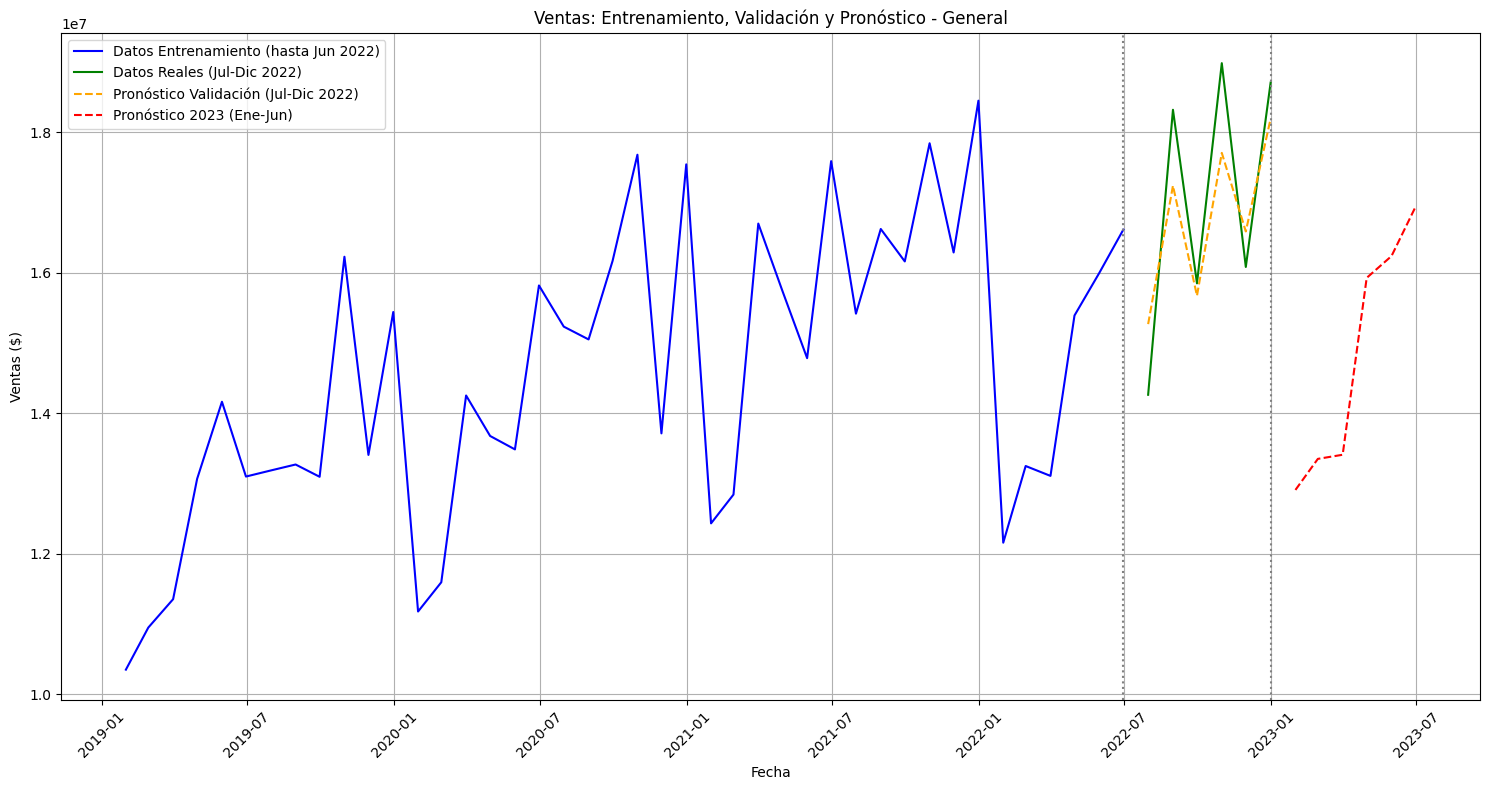

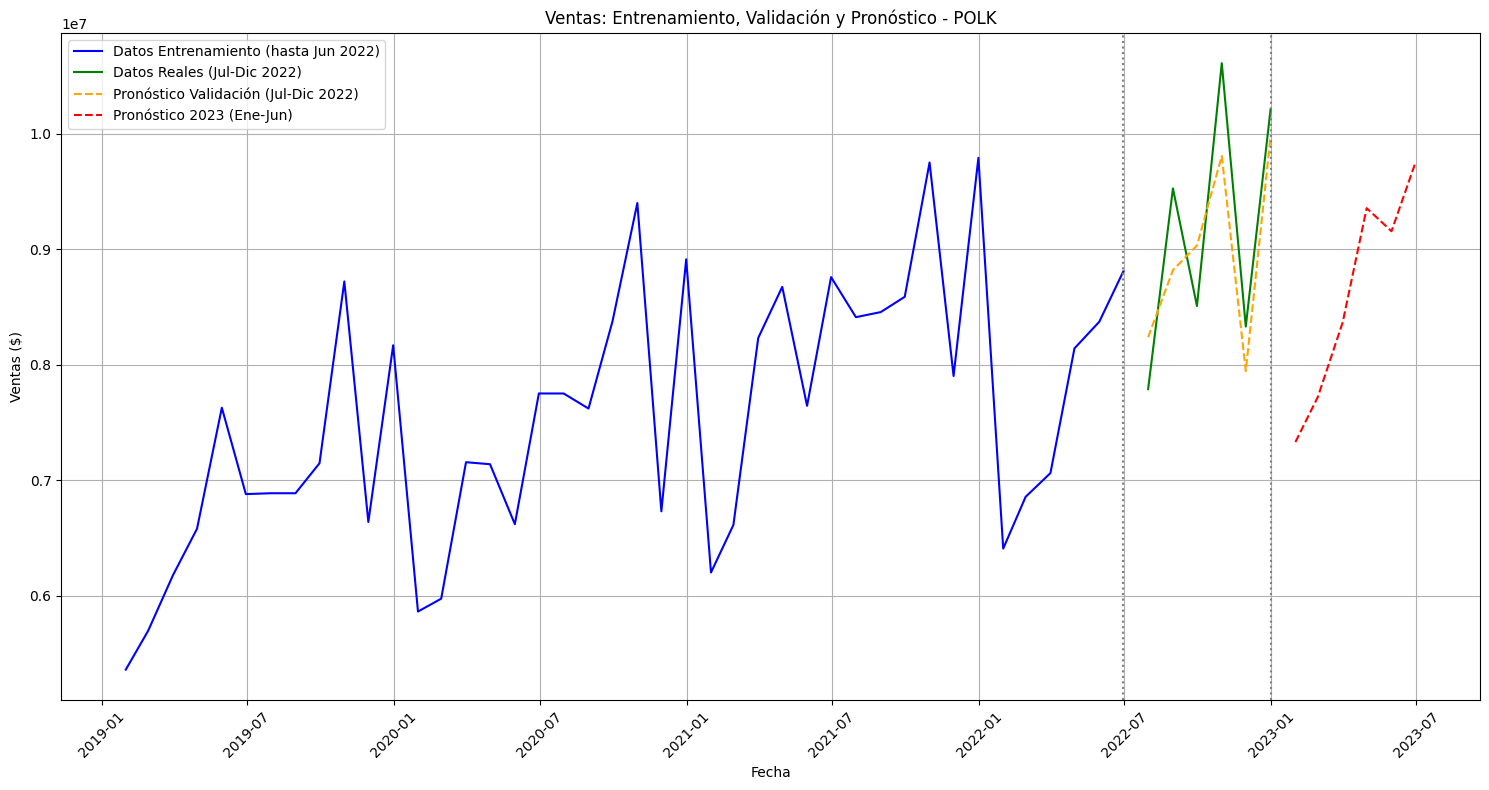

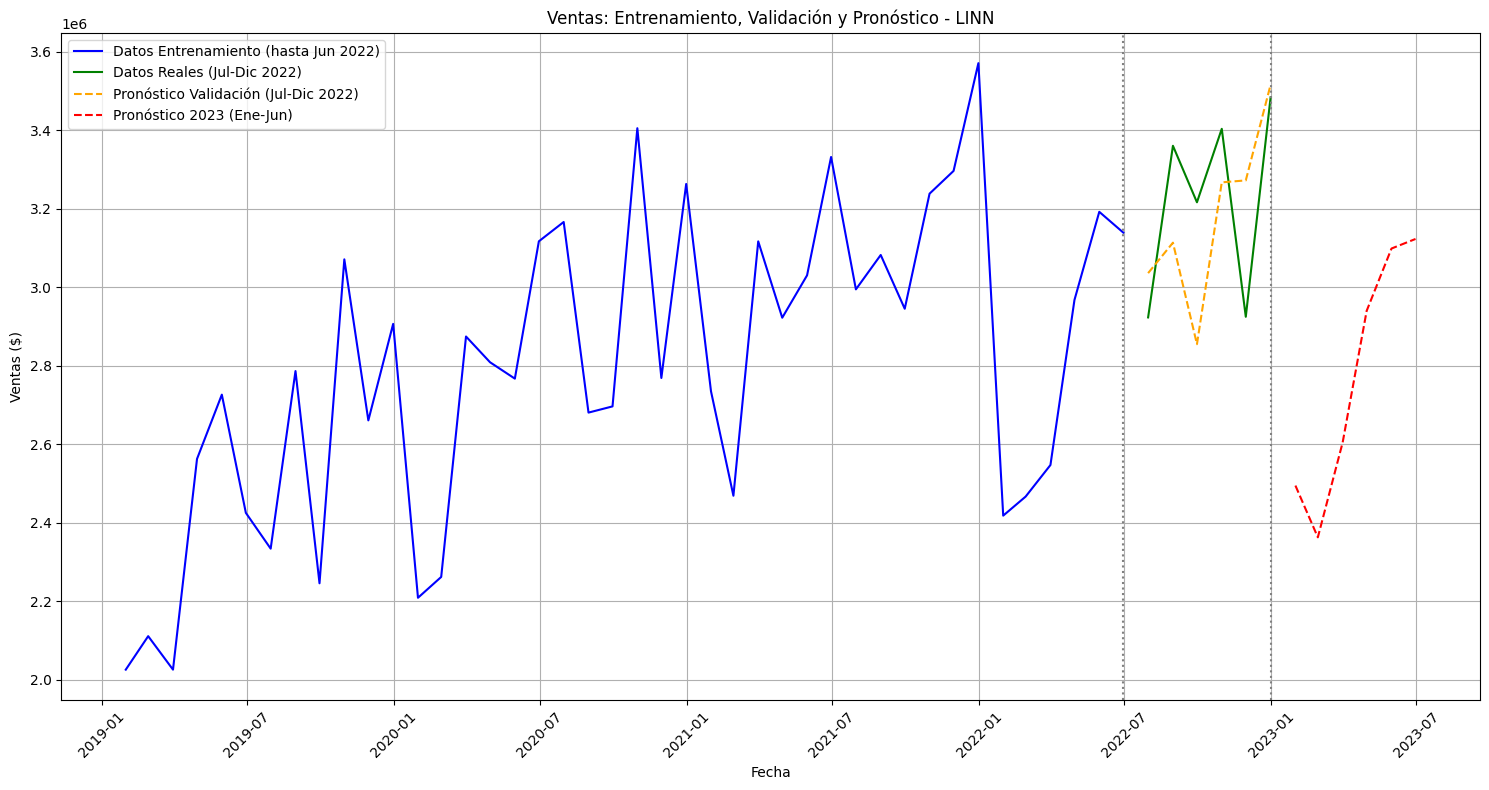

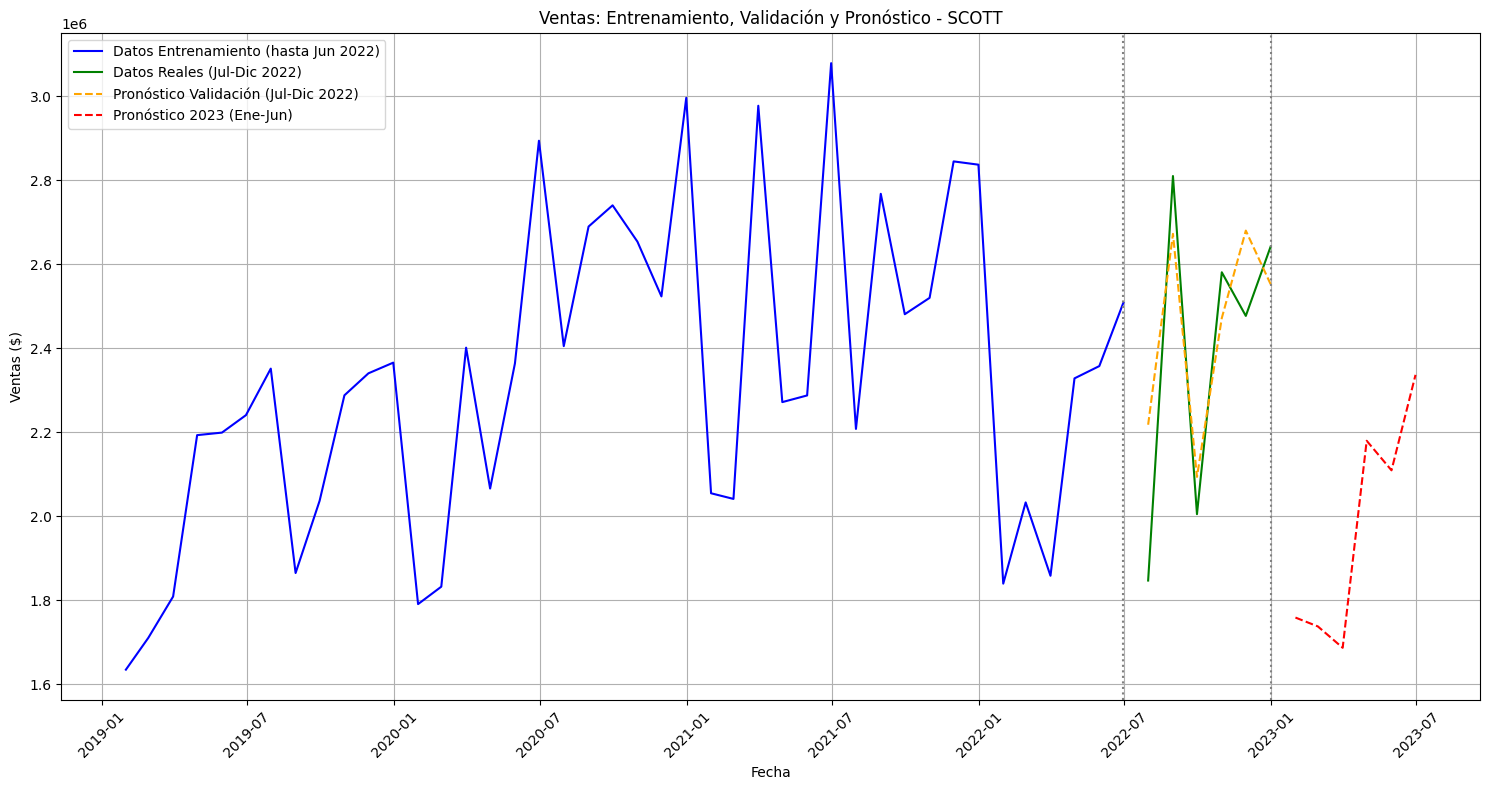

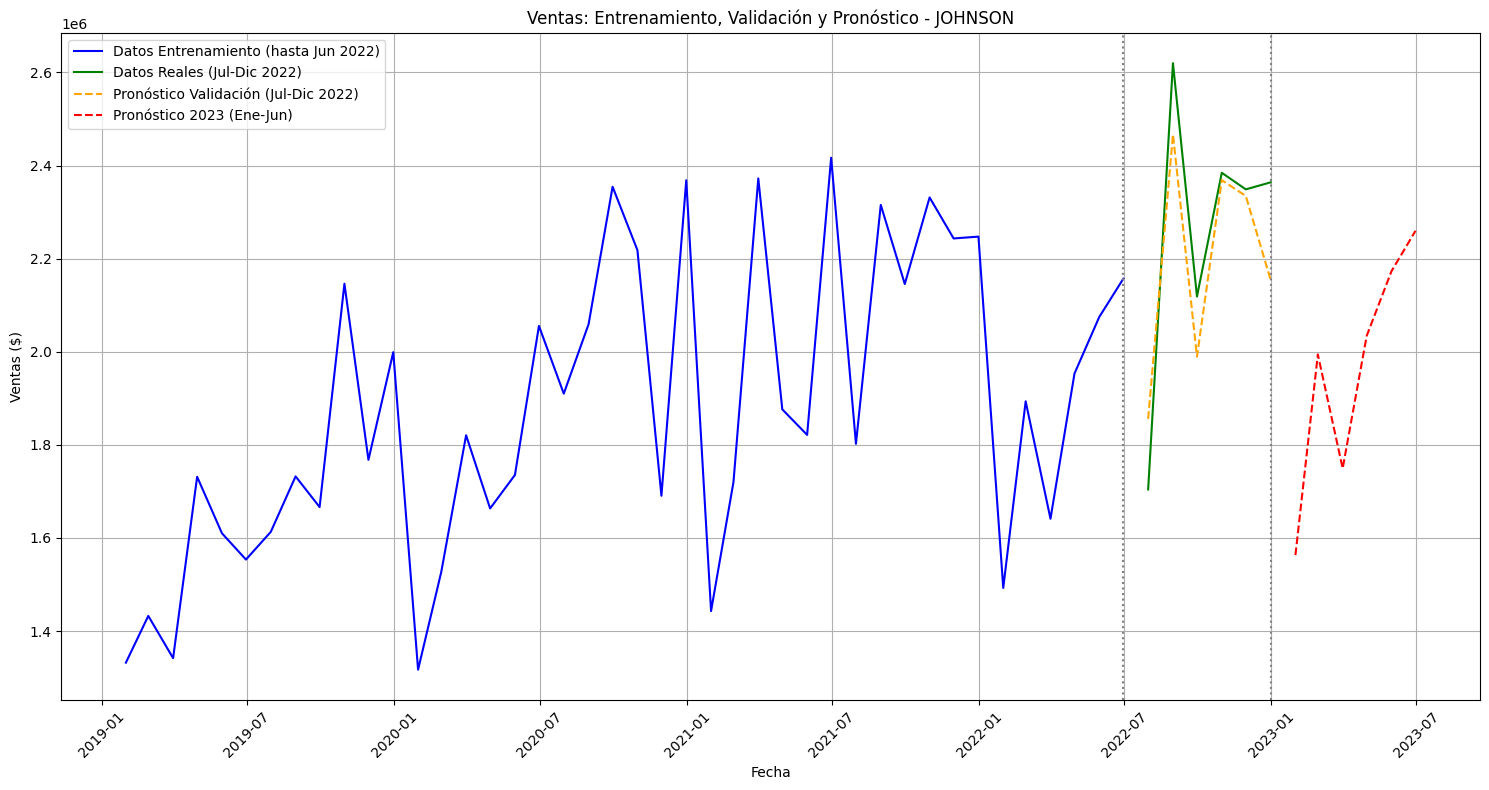

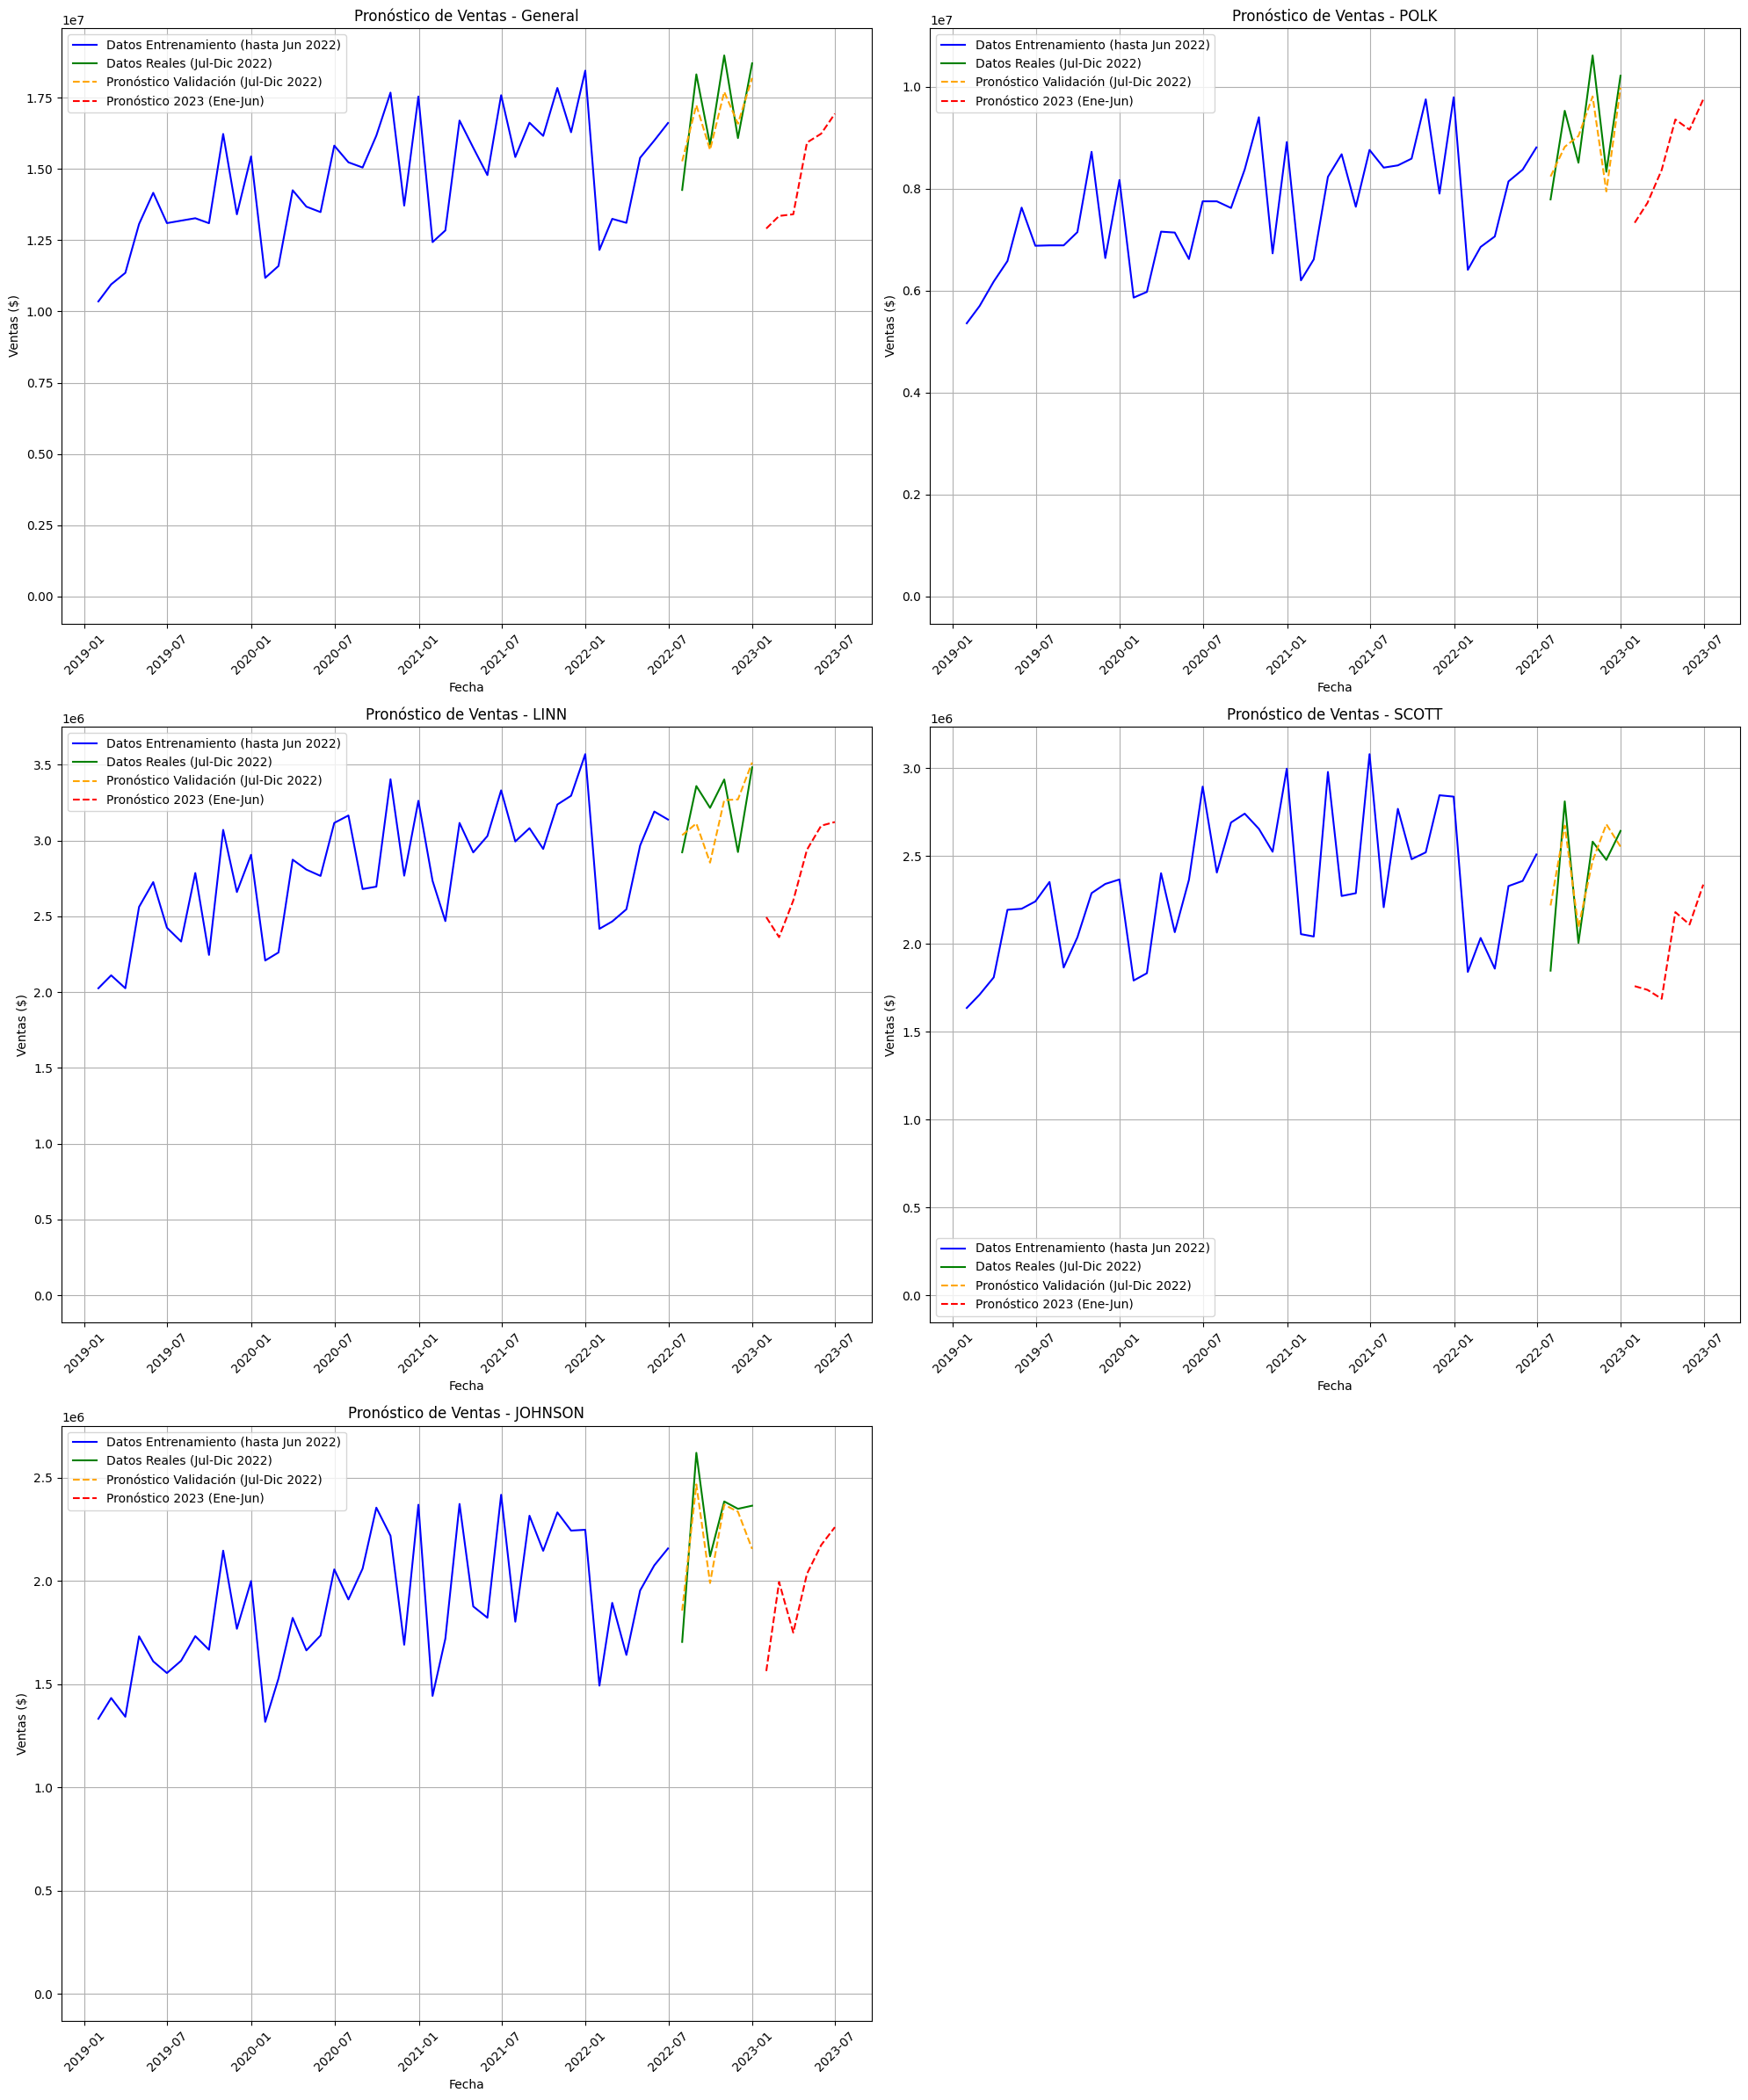

In [27]:
# Llamar a la función principal
validation_results, forecast_results, metrics_df, combined_plots = main(iowa_liquor)

if validation_results is not None:
    # Exportar los resultados de validación y pronóstico a CSV y Excel
    validation_df, forecast_df = create_results_df(validation_results, validation_results, forecast_results, county_name="General")
    # Descargar el archivo Excel
    from google.colab import files
    files.download('General_results.xlsx')
    # Mostrar resultados de validación
    print("\nResultados de Validación (Jul-Dic 2022):")
    print(validation_results.to_string())

    # Mostrar pronósticos
    print("\nPronósticos Enero-Junio 2023:")
    print(forecast_results.to_string())

    # Mostrar métricas y parámetros óptimos
    print("\nMétricas por Condado:")
    print(metrics_df.to_string())

    # Mostrar gráficos
    plt.show()
else:
    print("Error en el procesamiento de datos")



In [18]:
def plot_forecasts(plots):
    """
    Función para mostrar todos los gráficos
    """
    n_plots = len(plots)
    n_rows = (n_plots + 1) // 2

    fig = plt.figure(figsize=(20, 8 * n_rows))

    for idx, (county, plot_data) in enumerate(plots.items(), 1):
        plt.subplot(n_rows, 2, idx)

        lines = plot_data.get_axes()[0].get_lines()

        for line in lines:
            plt.plot(line.get_xdata(), line.get_ydata(),
                    label=line.get_label(),
                    color=line.get_color(),
                    linestyle=line.get_linestyle())

        plt.title(f'Pronóstico de Ventas - {county}')
        plt.xlabel('Fecha')
        plt.ylabel('Ventas ($)')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)

    plt.tight_layout()
    return fig

def format_metrics_df(metrics):
    """
    Formatea las métricas en un DataFrame
    """
    metrics_data = []
    for county, metric in metrics.items():
        if metric:
            params = metric.get('Params', (0,0,0,0,0,0,0))
            mape_value = metric['MAPE']
            if np.isnan(mape_value) or mape_value is None:
                mape_value = 0

            metrics_data.append({
                'Condado': county,
                'RMSE': round(float(metric['RMSE']), 2),
                'MAE': round(float(metric['MAE']), 2),
                'MAPE': round(float(mape_value), 2),
                'Parámetros (p,d,q)x(P,D,Q,s)': f"({params[0]},{params[1]},{params[2]})x({params[3]},{params[4]},{params[5]},{params[6]})"
            })

    return pd.DataFrame(metrics_data)

def process_county(df, county=None):
    """
    Procesa los datos para un condado específico o para todos los datos
    """
    county_name = county if county else "General"
    print(f"\nProcesando datos para {county_name}...")

    monthly_sales = prepare_time_series_data(df, county)
    train_data, validation_data = split_data_for_validation(monthly_sales)

    model_fit, validation_forecast, validation_metrics = train_and_validate_model(
        train_data, validation_data
    )

    if model_fit is None:
        return None

    best_params = validation_metrics['Params']
    final_model = train_final_model(monthly_sales, best_params)
    forecast_2023 = make_forecast_2023(final_model)

    plot = plot_county_results(train_data, validation_data, validation_forecast,
                             forecast_2023, county_name)

    validation_df, forecast_df = create_results_df(validation_data, validation_forecast,
                                                 forecast_2023, county_name)

    return {
        'validation_df': validation_df,
        'forecast_df': forecast_df,
        'metrics': validation_metrics,
        'plot': plot
    }

In [19]:
# Función principal para ejecutar todo en entrenamiento
#========================================================================================
def main(df):
    """
    Función principal que ejecuta todo el análisis
    """
    try:
        counties = ['POLK', 'LINN', 'SCOTT', 'JOHNSON']

        print("Iniciando análisis general...")
        all_results = process_county(df)

        if all_results is None:
            raise Exception("No se pudieron procesar los datos generales")

        county_results = {}
        for county in counties:
            result = process_county(df, county)
            if result is not None:
                county_results[county] = result

        all_validations = [all_results['validation_df']]
        all_forecasts = [all_results['forecast_df']]
        all_metrics = {'General': all_results['metrics']}
        all_plots = {'General': all_results['plot']}

        for county, results in county_results.items():
            all_validations.append(results['validation_df'])
            all_forecasts.append(results['forecast_df'])
            all_metrics[county] = results['metrics']
            all_plots[county] = results['plot']

        final_validation = pd.concat(all_validations, ignore_index=True)
        final_forecast = pd.concat(all_forecasts, ignore_index=True)
        metrics_df = format_metrics_df(all_metrics)
        combined_plots = plot_forecasts(all_plots)


        return final_validation, final_forecast, metrics_df, combined_plots

    except Exception as e:
        print(f"Error en la ejecución principal: {str(e)}")
        return None, None, None, None

Iniciando análisis general...

Procesando datos para General...
Buscando mejores parámetros...
Mejores parámetros encontrados: (2, 1, 1, 0, 1, 0, 12)

Procesando datos para POLK...
Buscando mejores parámetros...
Mejores parámetros encontrados: (2, 1, 0, 1, 1, 1, 12)

Procesando datos para LINN...
Buscando mejores parámetros...
Mejores parámetros encontrados: (2, 1, 0, 0, 1, 1, 12)

Procesando datos para SCOTT...
Buscando mejores parámetros...
Mejores parámetros encontrados: (2, 1, 0, 0, 1, 0, 12)

Procesando datos para JOHNSON...
Buscando mejores parámetros...
Mejores parámetros encontrados: (2, 1, 0, 0, 1, 0, 12)

Resultados de Validación (Jul-Dic 2022):
    Condado         Mes   Año  Ventas Reales  Ventas Pronosticadas  Error Absoluto  Error Porcentual
0   General       Julio  2022    14262297.15           15267709.01      1005411.86              7.05
1   General      Agosto  2022    18317184.25           17237423.45      1079760.80              5.89
2   General  Septiembre  2022    

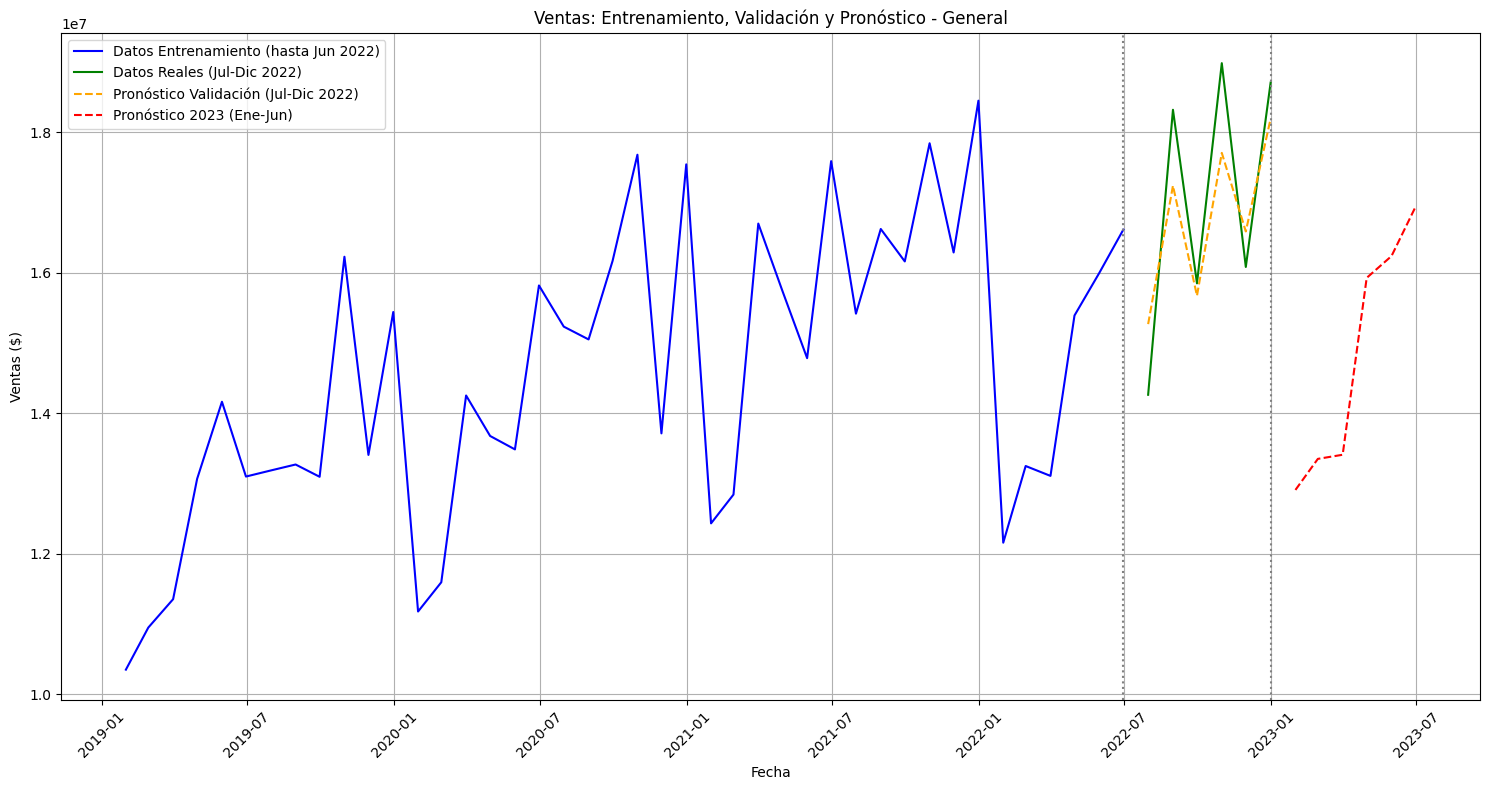

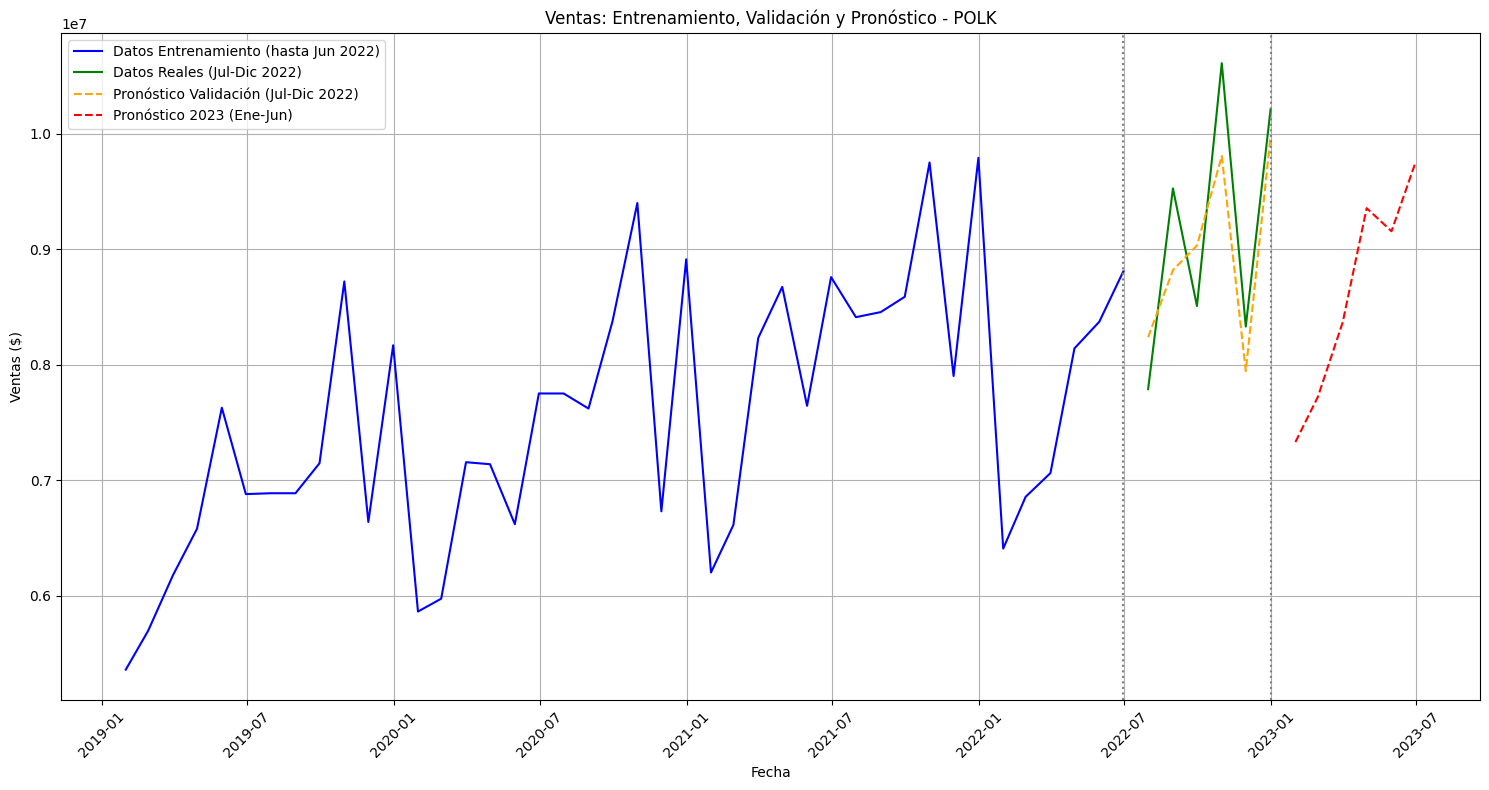

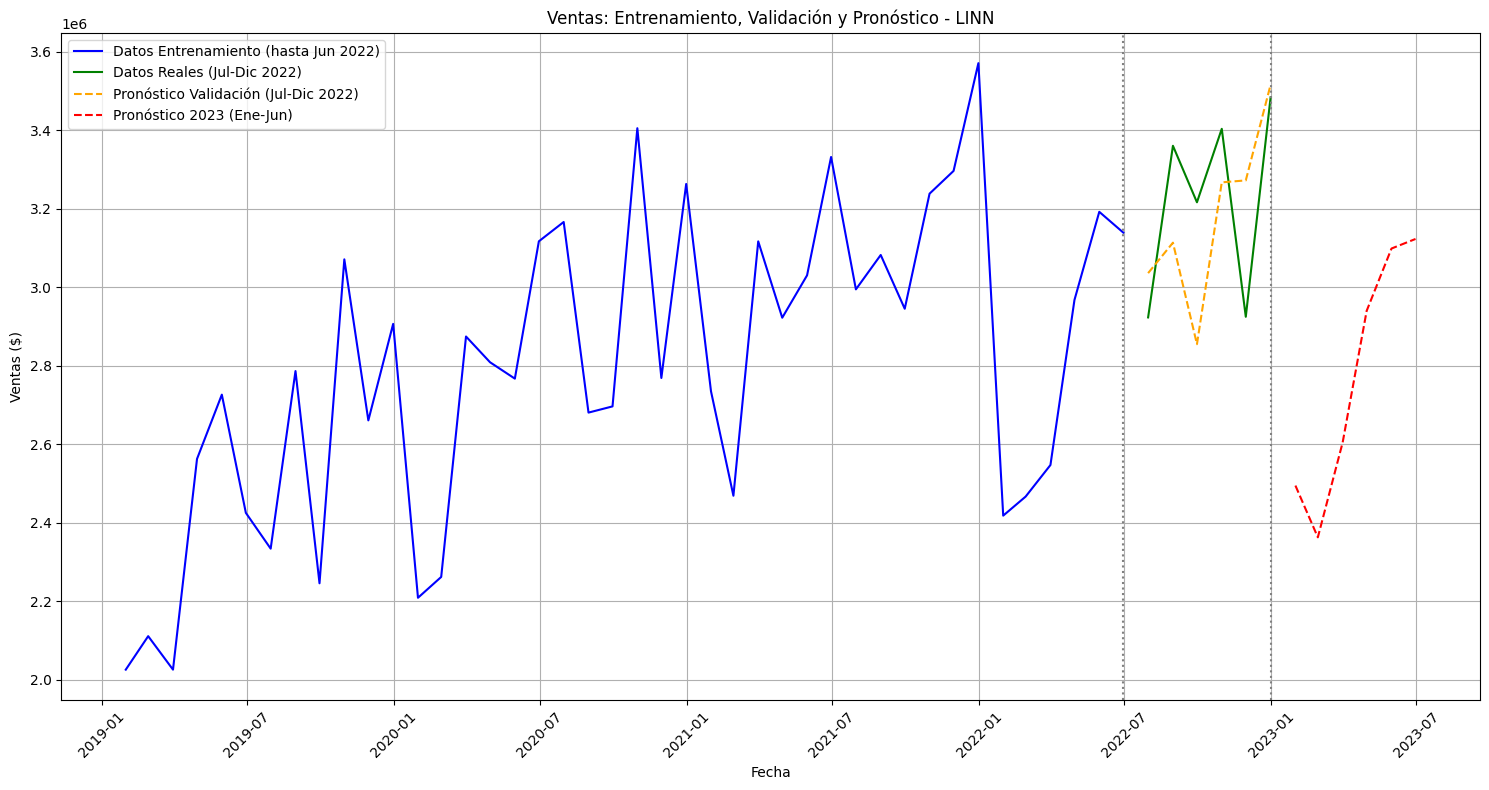

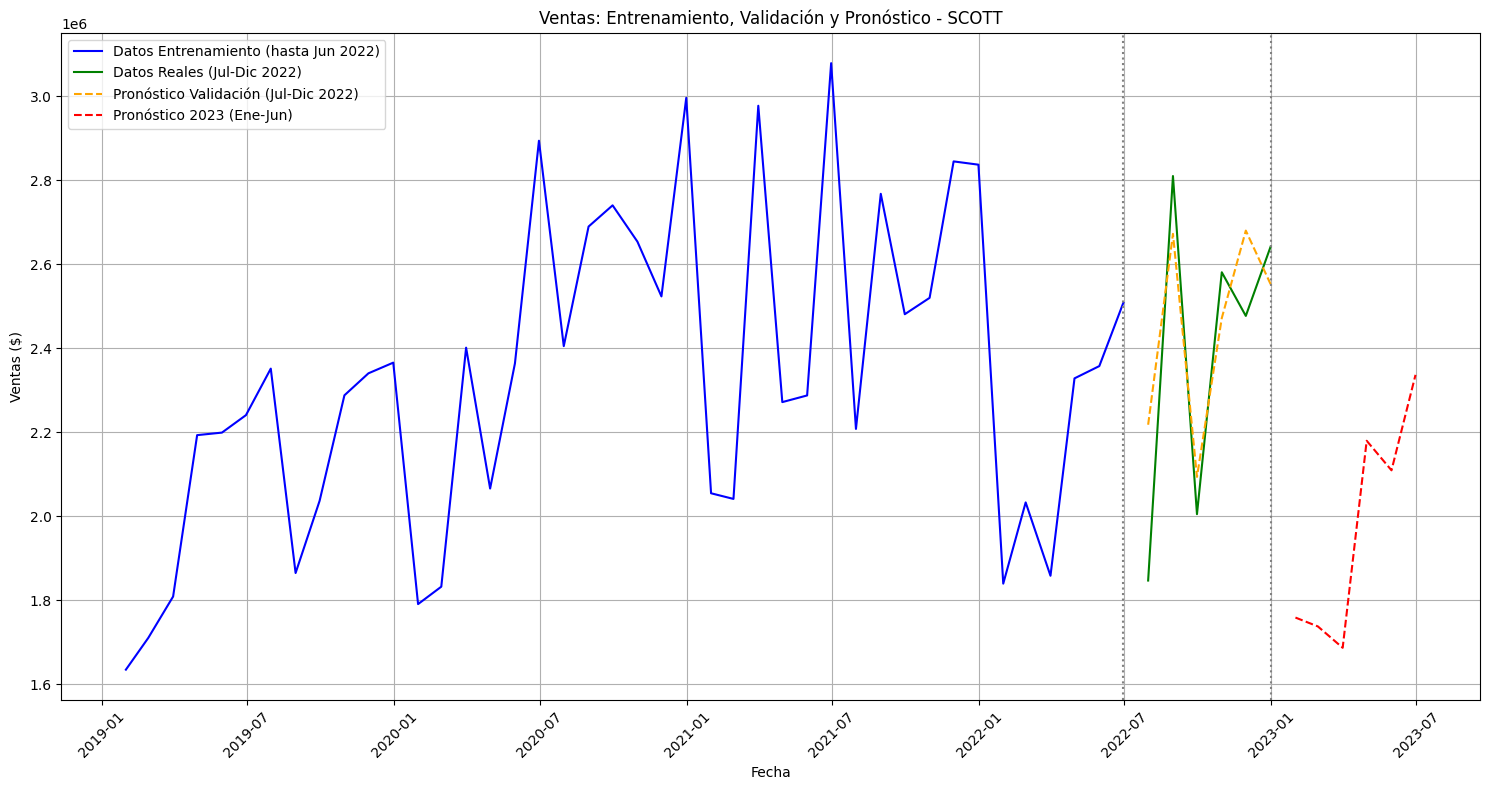

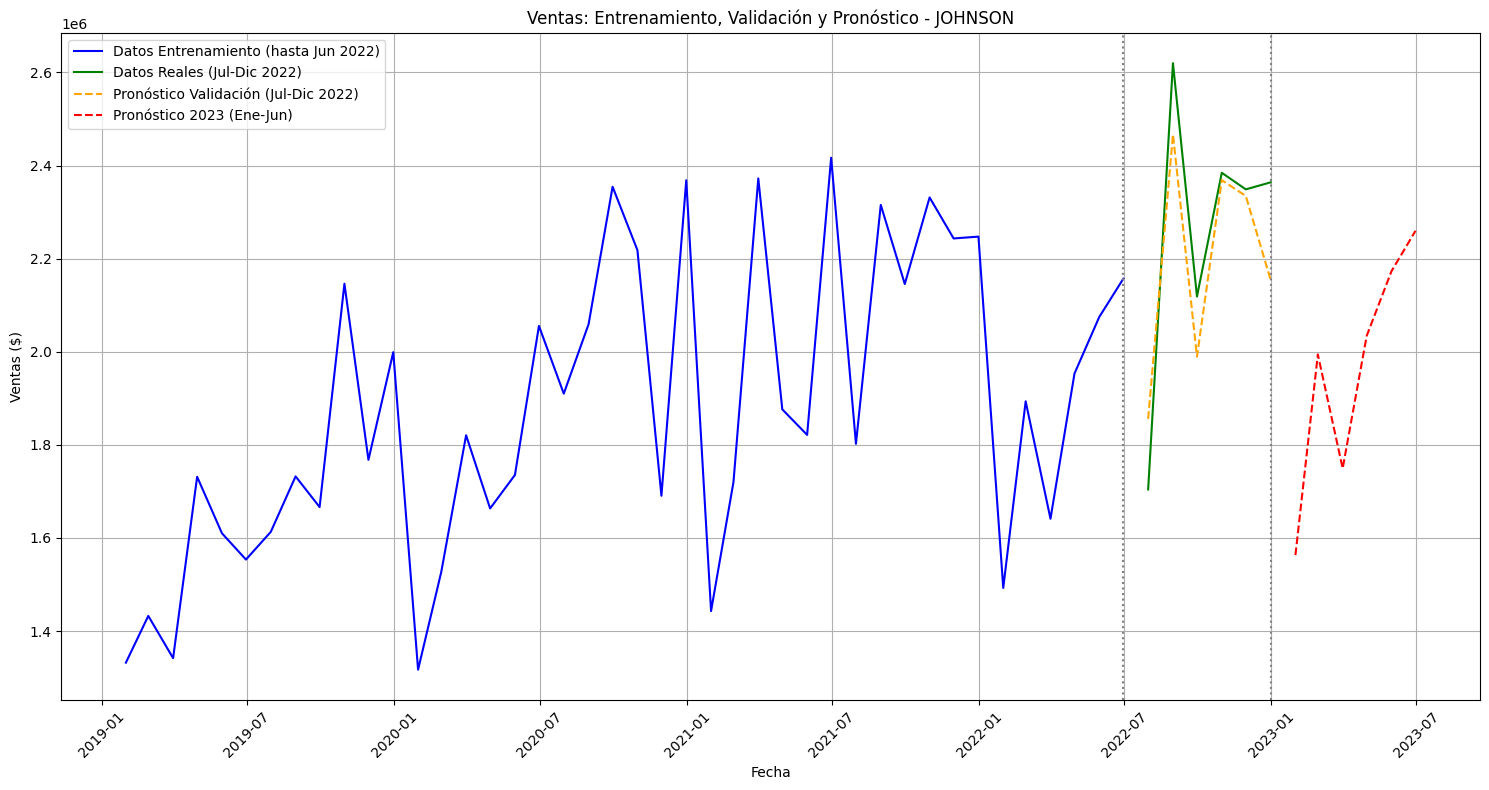

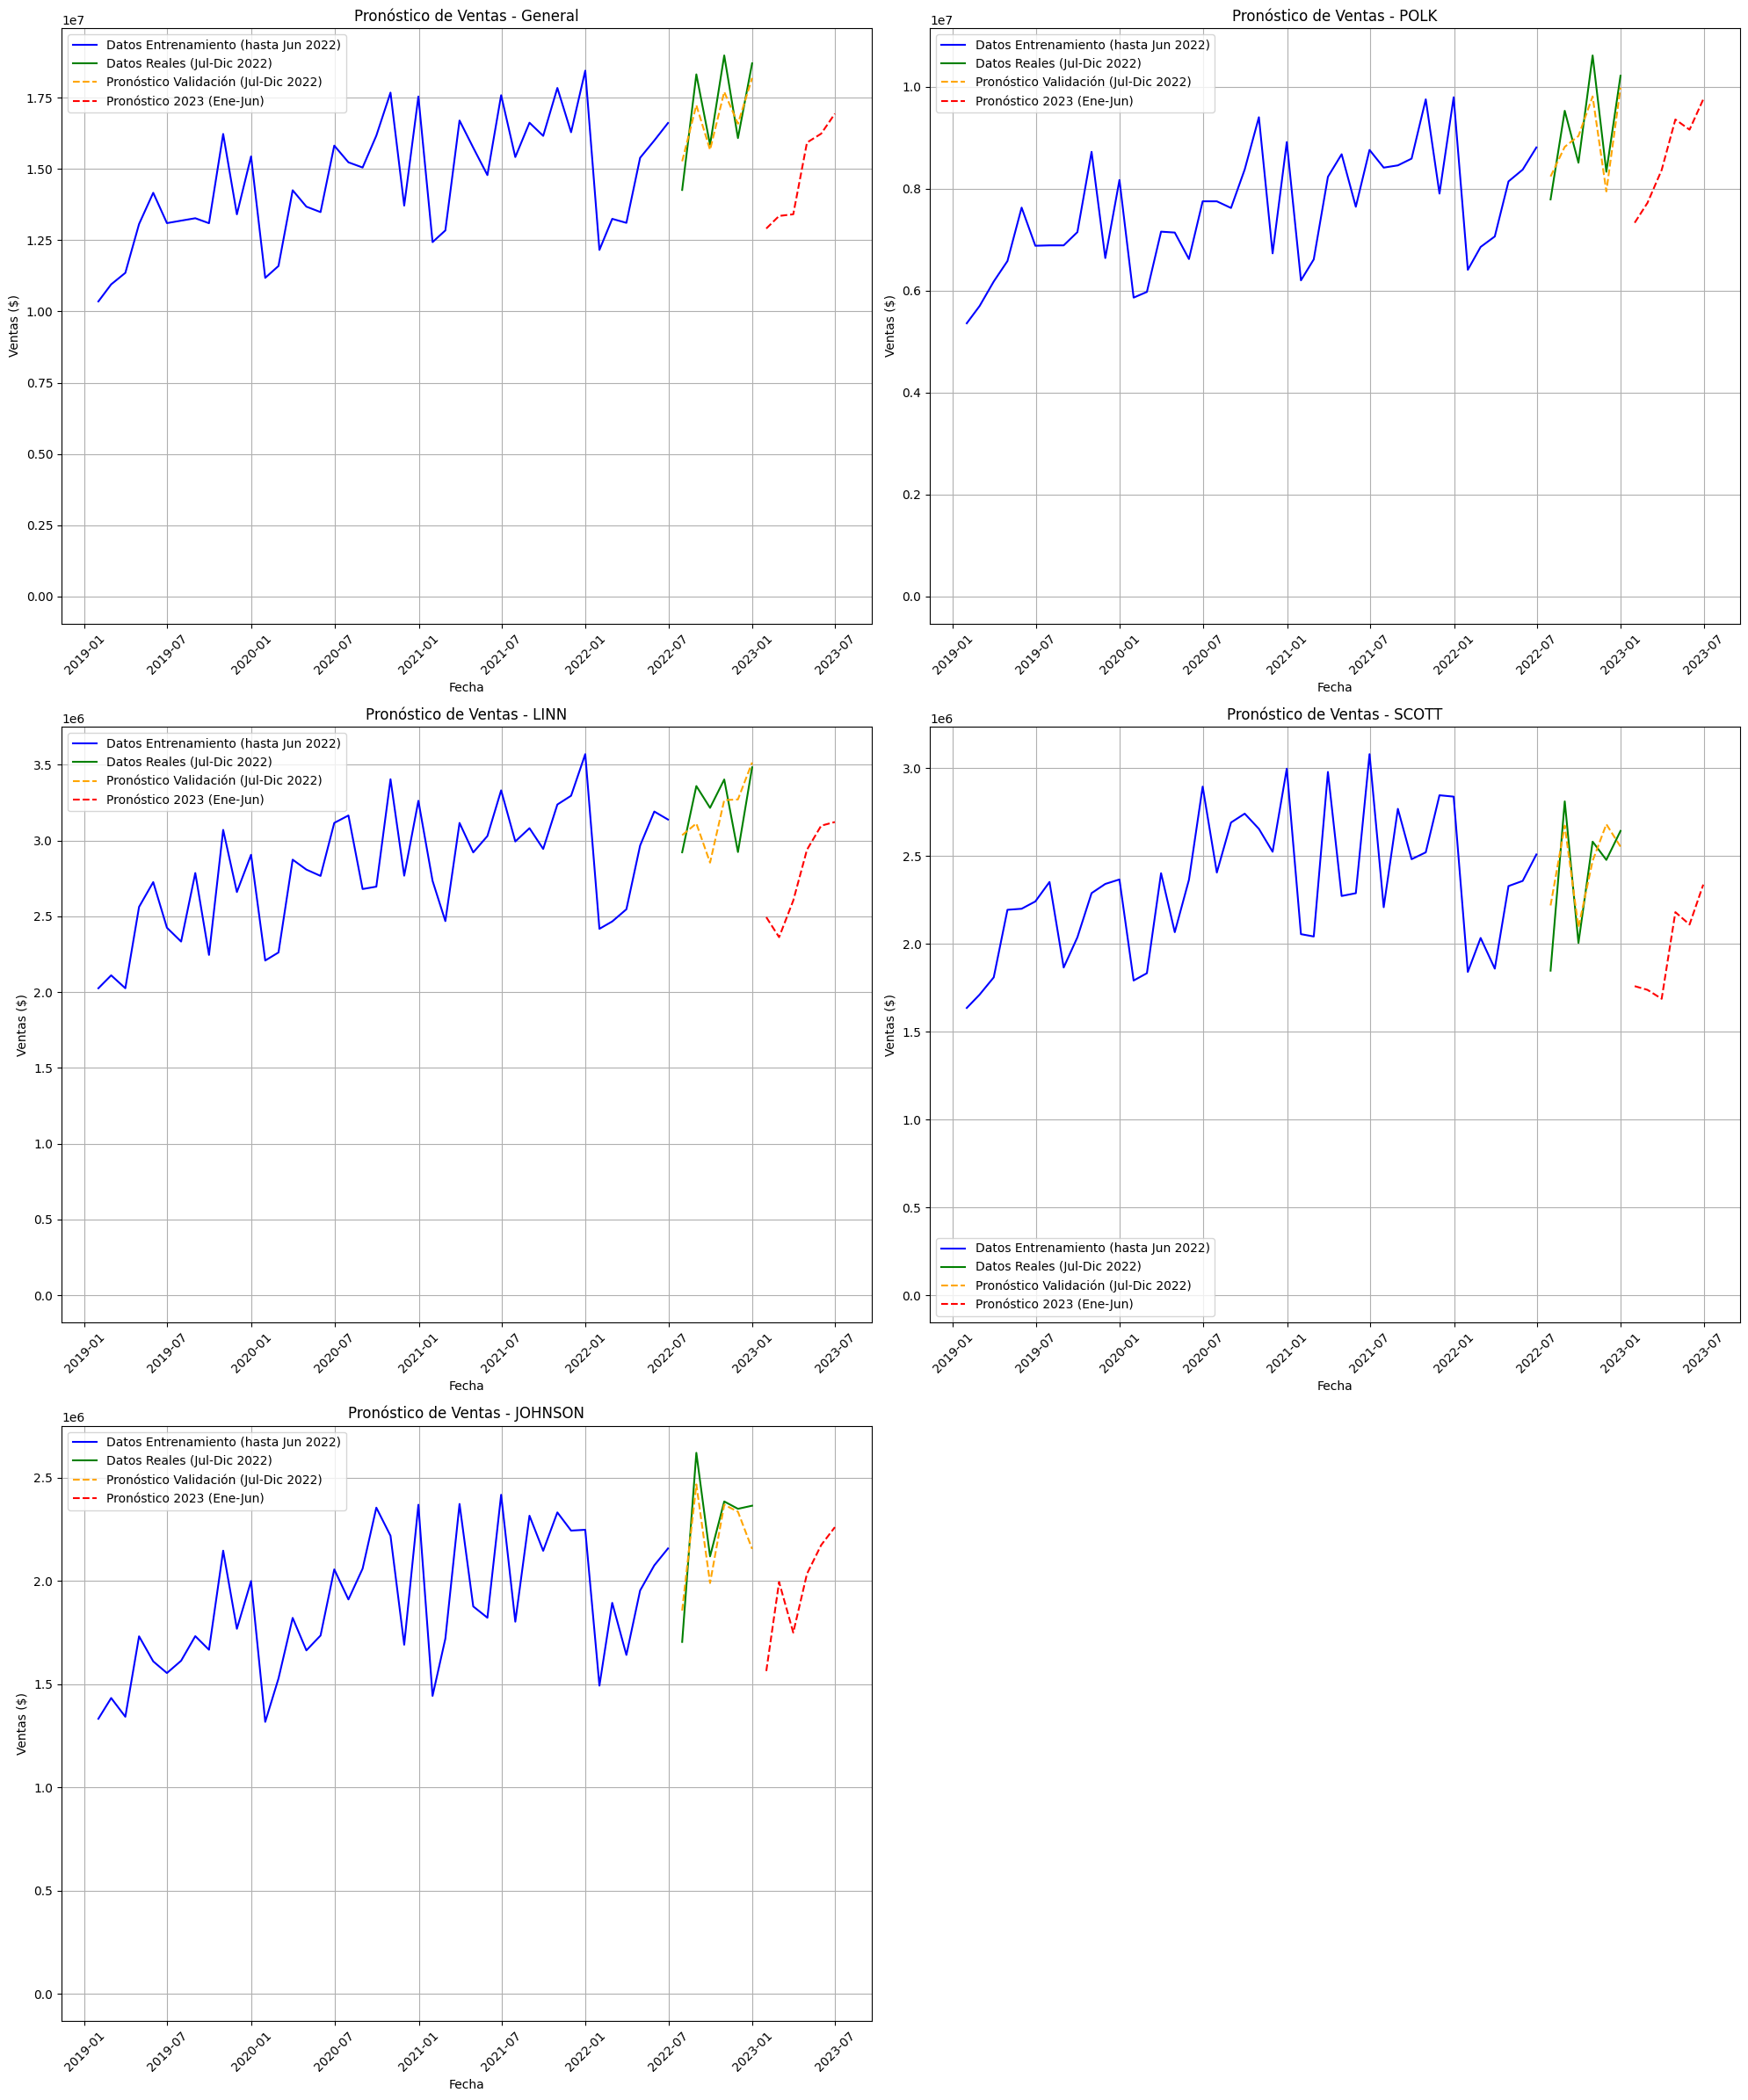

In [20]:
# Ejecutar el main
#=====================================================================================
validation_results, forecast_results, metrics_df, combined_plots = main(iowa_liquor)

if validation_results is not None:
    # Mostrar resultados de validación
    print("\nResultados de Validación (Jul-Dic 2022):")
    print(validation_results.to_string())

    # Mostrar pronósticos
    print("\nPronósticos Enero-Junio 2023:")
    print(forecast_results.to_string())

    # Mostrar métricas y parámetros óptimos
    print("\nMétricas por Condado:")
    print(metrics_df.to_string())

    # Mostrar gráficos
    plt.show()
else:
    print("Error en el procesamiento de datos")


In [11]:
validation_df.to_csv(f'{county_name}_validation_results.csv', index=False)
forecast_df.to_csv(f'{county_name}_forecast_results.csv', index=False)

NameError: name 'validation_df' is not defined

Conclusiones:

1.	Desempeño General del Modelo:
    -	El modelo muestra un buen desempeño general, con MAPE (Error Porcentual Medio Absoluto) por debajo del 10% para todos los condados.
    -	Los parámetros SARIMA óptimos son similares para todos los condados: (2,1,0)x(0/1,1,0,12), lo que sugiere un patrón estacional consistente

2.	Análisis por Condado:
a)	General (Todo el estado):
    -	MAPE más bajo (4,45%)
    -	RMSE más alto (852078.90) debido al mayor volumen de ventas
    -	Mejor precisión en términos relativos
    -	Muy buen rendimiento para pronósticos agregados
b) POLK:
    -	MAPE de 5,64%
    -	Error porcentual más alto en julio y octubre (5-7%)
    -	Buena consistencia en los pronósticos
    -	Mayor estabilidad en los últimos meses
c) LINN:
    -	MAPE de 6,54%
    -	Muestra algunos picos de error en septiembre y noviembre (11%)
    -	Comportamiento más volátil que otros condados
    -	Necesita más atención en meses de alta variabilidad
d) SCOTT:
    -	MAPE de 7,54% (el más alto)
    -	Error notable en julio (20,09%)
    -	Mayor variabilidad en los pronósticos.
    -	Podría beneficiarse de ajustes adicionales
e) JOHNSON:
    -	MAPE de 5,16%
    -	Mejora significativa en los últimos meses
    -	Errores más bajos en octubre-noviembre (<1%)
    -	Buen rendimiento general

3.	Recomendaciones:
    -	El modelo es más confiable para pronósticos generales del estado.
    -	SCOTT requiere atención especial, especialmente en julio
    -	LINN podría necesitar ajustes para meses específicos
    -	El modelo es particularmente efectivo para JOHNSON en meses recientes
    -	Se podrían considerar ajustes estacionales específicos para cada condado.


4.	Fortalezas del Modelo:
    -	Consistente en todos los condados
    -	Errores generalmente bajos (<10%)
    -	Mejor rendimiento en pronósticos agregados
    -	Captura bien la estacionalidad (componente 12 meses)

5.	Limitaciones:
    -	Mayor variabilidad en condados específicos
    -	Algunos picos de error en meses particulares
    -	Rendimiento variable según el condado
    
En general, el modelo muestra un buen desempeño y es confiable para pronósticos, especialmente a nivel estatal, aunque podría beneficiar de ajustes específicos para ciertos condados en meses particulares.
